## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gym==0.21.0
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 01. DQN

[V. Mnih et al., "Human-level control through deep reinforcement learning." Nature, 518
(7540):529–533, 2015.](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

Reinforcement learning is known to be unstable or even to diverge when a nonlinear function approximator such as a neural network is used to represent the action-value (also known as $Q$) function. This instability has several causes: the correlations present in the sequence of observations, the fact that small updates to $Q$ may significantly change the policy and therefore change the data distribution, and the correlations between the action-values ($Q$) and the target values $r + \gamma \max_{a'} Q(s', a')$.

The authors suggest two key ideas to address these instabilities with a novel variant of Q-learning: Replay buffer and Fixed Q-target.

#### Uniformly random sampling from Experience Replay Memory

Reinforcement learning agent stores the experiences consecutively in the buffer, so adjacent ($s, a, r, s'$) transitions stored are highly likely to have correlation. To remove this, the agent samples experiences uniformly at random from the pool of stored samples $\big( (s, a, r, s') \sim U(D) \big)$. See sample_batch method of ReplayBuffer class for more details.

#### Fixed Q-target

DQN uses an iterative update that adjusts the action-values ($Q$) towards target values that are only periodically updated, thereby reducing correlations with the target; if not, it is easily divergy because the target continuously moves. The Q-learning update at iteration $i$ uses the following loss function:

$$
L_i(\theta_i) = \mathbb{E}_{(s,a,r,s') \sim U(D)} \big[ \big( r + \gamma \max_{a'} Q(s',a';\theta_i^-) - Q(s, a; \theta_i) \big)^2 \big]
$$

in which $\gamma$ is the discount factor determining the agent’s horizon, $\theta_i$ are the parameters of the Q-network at iteration $i$ and $\theta_i^-$ are the network parameters used to compute the target at iteration $i$. The target network parameters $\theta_i^-$ are only updated with the Q-network parameters ($\theta_i$) every C steps and are held fixed between individual updates. ($C = 200$ in CartPole-v0)

#### For more stability: Gradient clipping

The authors also found it helpful to clip the error term from the update $r + \gamma \max_{a'} Q(s', a'; \theta_i^-) - Q(s,a,;\theta_i)$ to be between -1 and 1. Because the absolute value loss function $|x|$ has a derivative of -1 for all negative values of x and a derivative of 1 for all positive values of x, clipping the squared error to be between -1 and 1 corresponds to using an absolute value loss function for errors outside of the (-1,1) interval. This form of error clipping further improved the stability of the algorithm.

In [2]:
import os
from typing import Dict, List, Tuple

import gym
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Replay buffer

Typically, people implement replay buffers with one of the following three data structures:

  - collections.deque
  - list
  - numpy.ndarray
  
**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of  *Get item* is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference). Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.


Reference: [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

In [4]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

## Dataset

Using the preprocessed datasets by Laurens D'Hooge (https://gitlab.ilabt.imec.be/lpdhooge/clean-ids-collection)

In [5]:
nslkdd_train = pd.read_feather("./datasets/nsl-kdd/KDDTrain.feather")
nslkdd_test = pd.read_feather("./datasets/nsl-kdd/KDDTest.feather")
# data = pd.concat([nslkdd_test], ignore_index=True)
# print(len(data.columns))

# nslkdd_train.protocol_type = pd.Categorical(nslkdd_train.protocol_type).codes
# nslkdd_train.service = pd.Categorical(nslkdd_train.service).codes
# nslkdd_train.flag = pd.Categorical(nslkdd_train.flag).codes


# nslkdd_test.protocol_type = pd.Categorical(nslkdd_test.protocol_type).codes
# nslkdd_test.service = pd.Categorical(nslkdd_test.service).codes
# nslkdd_test.flag = pd.Categorical(nslkdd_test.flag).codes


nslkdd_train = pd.get_dummies(nslkdd_train,columns=['protocol_type' ,'service', 'flag'])
nslkdd_test = pd.get_dummies(nslkdd_test, columns=['protocol_type' ,'service', 'flag'])
nslkdd_train.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
nslkdd_train.info()
nslkdd_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Columns: 123 entries, duration to flag_SH
dtypes: float64(15), int64(23), object(1), uint8(84)
memory usage: 47.6+ MB


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.00000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,0.08917,0.012399,0.000818,0.019218,0.276655,0.002897,0.001008,0.000389,0.594929,0.002151
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,0.28499,0.110661,0.028583,0.137292,0.447346,0.053750,0.031736,0.019719,0.490908,0.046332
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
def balancing_dataset_sampler_df(df, train_frac=0.2, val_frac=0.1, test_frac=0.7):
    col = df.columns[-1]
    print(col)
    cols = df.columns[:-1]
    print(cols)
    vc = df[col].value_counts()
    print(vc)
    n = vc.iloc[-1]
    print(n)
    m = vc.iloc[0]
    print(m)
    print(int(m-n))
    initial_cut = df.loc[df[col] == vc.index[0]].sample(n=int(m-n), replace=False)
    print(initial_cut.index)
    df = df.drop(index=initial_cut.index)
    vc = df[col].value_counts()
    print(vc)
    print(int(n*train_frac))
    train_df = df.groupby(col).apply(lambda x: x.sample(n=int(n*train_frac), replace=False))
    train_df.reset_index(level=0, inplace=True, drop=True)
    df = df.drop(index=train_df.index)

    validation_df = df.groupby(col).apply(lambda x: x.sample(n=int(n*val_frac), replace=False))
    validation_df.reset_index(level=0, inplace=True, drop=True)
    df = df.drop(index=validation_df.index)

    test_df = df.groupby(col).apply(lambda x: x.sample(n=int(n*test_frac), replace=False))
    test_df.reset_index(level=0, inplace=True, drop=True)
    df = df.drop(index=test_df.index)

    return train_df[cols], train_df[col], validation_df[cols], validation_df[col], test_df[cols], test_df[col]


In [8]:
def nslkdd_split_df(train_df, test_df):
    train_col = train_df.columns[-1]
    print(train_col)
    train_cols = train_df.columns[:-1]
    print(train_cols)
    test_col = test_df.columns[-1]
    print(test_col)
    test_cols = test_df.columns[:-1]
    print(test_cols)

    return train_df[train_cols], train_df[train_col], test_df[test_cols], test_df[test_col]

In [9]:
def malicious_benign(df):
    print(df['class'].value_counts())
    df['class'] = df['class'].astype('object')
    atk_idx = df.loc[df['class'] != "normal"].index
    df.loc[atk_idx, 'class'] = 1.0
    df.loc[df.index.difference(atk_idx), 'class'] = 0.0
    df['class'] = df['class'].astype(dtype=np.float32)

In [10]:
malicious_benign(nslkdd_train)
print()
malicious_benign(nslkdd_test)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: class, dtype: int64

normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel    

In [11]:
extra_removables = nslkdd_test.columns ^ nslkdd_train.columns
print(extra_removables)
try:
    nslkdd_train = nslkdd_train.drop(labels=extra_removables, axis='columns')
except:
    pass
try:
    nslkdd_test.drop(labels=extra_removables, axis='columns')
except:
    pass
nslkdd_train.info()

Index(['service_aol', 'service_harvest', 'service_http_2784',
       'service_http_8001', 'service_red_i', 'service_urh_i'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Columns: 117 entries, duration to flag_SH
dtypes: float32(1), float64(15), int64(23), uint8(78)
memory usage: 46.4 MB


C:\Users\rebus\AppData\Local\Temp\ipykernel_17864\366472954.py:1: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  extra_removables = nslkdd_test.columns ^ nslkdd_train.columns


In [12]:
x_train, y_train, x_test, y_test  = nslkdd_split_df(nslkdd_train, nslkdd_test)

flag_SH
Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF'],
      dtype='object', length=116)
flag_SH
Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF'],
      dtype='object', length=116)


In [13]:
y_train = y_train.to_frame()
y_test = y_test.to_frame()

# custom keys -> replace by index

x_train = x_train.set_index([pd.Index(range (0, len(x_train)))])
y_train = y_train.set_index([pd.Index(range (0, len(y_train)))])
x_test = x_test.set_index([pd.Index(range (0, len(x_test)))])
y_test = y_test.set_index([pd.Index(range (0, len(y_test)))])


## DQN Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |


In [14]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
        self.env.close()
                
    def test(self) -> None:
        """Test the agent."""
        self.is_test = True
        TP, FP, TN, FN = 0,0,0,0
        # for recording a video
        naive_env = self.env
        self.env = IdsEnv(images_per_episode=1, dataset=(x_test, y_test), random=False)

        action = self.env.reset()
        done = False
        count = 0
        try:
            while True:

                done = False
                while not done:
                    count += 1
                    action = self.select_action(action)
                    next_action, rew, done, info = self.env.step(action)
                    action = next_action
                    label = info['label']
                    if label == 0 and rew > 0:
                        TP += 1
                    if label == 0 and rew == 0:
                        FP += 1
                    if label == 1 and rew > 0:
                        TN += 1
                    if label == 1 and rew == 0:
                        FN += 1
        except StopIteration:
            accuracy = (float(TP + TN) / (TP + FP + FN + TN)) 
            precision = (float(TP) / (TP + FP))
            try:
                recall = (float(TP) / (TP + FN)) # = TPR = Sensitivity
            except:
                recall = 0
            try:
                FPR = (float(FP) / (TN + FP)) # 1 - specificity
            except:
                FPR = 0
            try:
                f1_score = 2 * (precision * recall) / (precision + recall)
            except:
                f1_score = 0
            print()
            print('validation done...')
            print('Accuracy: {0}%'.format(accuracy * 100))
            print('Precision: {0}%'.format(precision * 100))
            print('Recall/TPR/Sensitivity: {0}%'.format(recall * 100))
            print('FPR: {0}%'.format(FPR * 100))
            print('F1 score: {0}'.format(f1_score))
            print('count: {0}'.format(count))
        self.env.close()

        # reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(
            next_state
        ).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

## Environment

You can see the [code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) and [configurations](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L53) of CartPole-v0 from OpenAI's repository.

In [15]:
class IdsEnv(gym.Env):
    def __init__(self, images_per_episode=1, dataset=(x_train, y_train), random=True):
        # Actions we can take, classify as malicious or non-malicious (later also the correct attack)
        # change to 19 if detectiong all different attacks
        self.action_space = gym.spaces.Discrete(2)
         # All the features we have, len(important_features) - 1 features and 1 label. Label should not be included
        self.observation_space = gym.spaces.Box(low=float('-inf'), high=float('inf'), shape=(len(nslkdd_train.columns) - 1,))
        self.images_per_episode = images_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0
    
    def step(self, action):
        done = False
        reward = int(action == self.expected_action)
        current_label = self.expected_action
        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, {'label': current_label}

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y.iloc[next_obs_idx,:])
            obs = self.x.iloc[next_obs_idx,:]

        else:
            obs = self.x.iloc[self.dataset_idx]
            self.expected_action = int(self.y.iloc[self.dataset_idx])

            self.dataset_idx += 1
            if self.dataset_idx >= len(self.x):
                raise StopIteration()
        return obs
    
    def reset(self):
        self.step_count = 0

        obs = self._next_obs()
        return obs

In [16]:
# environment
env = IdsEnv(images_per_episode=1000)

## Set random seed

In [17]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

C:\Users\rebus\anaconda3\envs\MP\lib\site-packages\gym\core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


[777]

## Initialize

In [18]:
# parameters
num_frames = int(1.0e5)
memory_size = 100000
batch_size = 128
target_update = 10000
epsilon_decay = 1 / 10000

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay)

cuda


## Train

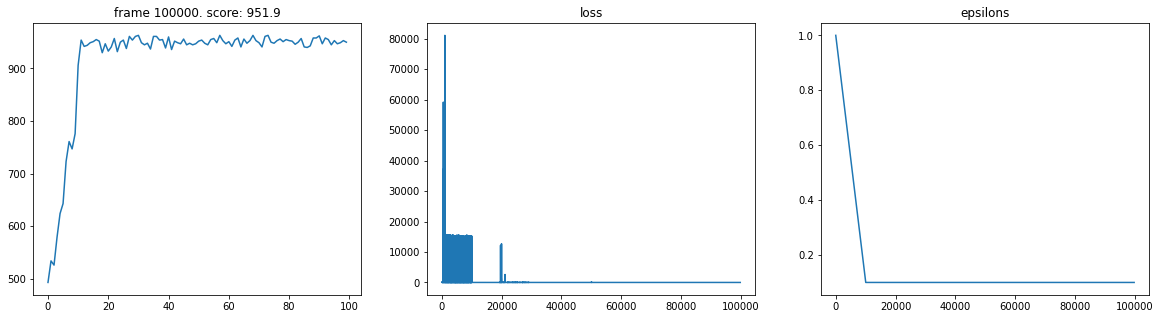

DQN Training Time: 410.5013062953949


In [19]:
start_time = time.time()
agent.train(num_frames)
print("DQN Training Time:", time.time() - start_time)

## Test

In [20]:
agent.test()


validation done...
Accuracy: 95.2311241238577%
Precision: 95.2245315768392%
Recall/TPR/Sensitivity: 99.9906533320871%
FPR: 93.7937062937063%
F1 score: 0.9754941071876353
count: 22543
